## Setup


In [1]:
import json
import wandb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from snorkel.utils import preds_to_probs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import torch
import random
import transformers
import torch.nn.functional as F
from huggingface_hub import login
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import Trainer, TrainingArguments
from arabert.preprocess import ArabertPreprocessor

sns.set()
%matplotlib inline

In [2]:
sns.set_style("whitegrid", {"axes.grid": False})

In [3]:
# project name for wandb.ai
project_name = "Arabic-Weakly-Supervised-Propaganda-Detection"
run_name = "apl-nce-1.0-mae-1.0"
# run_name = "weighted-cross-entropy-soft"

# defining data paths
# snorkel_data_path = "../data/processed/train.json"
# lf_dev_data_path = "../data/processed/lf_dev.json"
# test_data_path = "../data/processed/test_data.json"
# access_tokens_path = "../data/access_tokens.json"

# defining data paths
snorkel_data_path = "./train.json"
lf_dev_data_path = "./lf_dev.json"
test_data_path = "./test_data.json"
access_tokens_path = "./access_tokens.json"

# defining model names
seed = 42
model_ckpt = "aubmindlab/bert-base-arabertv2"
model_name = "arabertv2-weakly-supervised-arabic-propaganda"
model_path = f"./models/{model_name}"

In [4]:
with open(access_tokens_path) as f:
    access_tokens = json.load(f)

In [5]:
login(access_tokens["huggingface"]["write_token"])

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [6]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
transformers.set_seed(seed)

## Data Preprocessing


In [7]:
data = pd.read_json(snorkel_data_path)
data.head(2)

,tweetid,text,label,probs
0,1424769773917908992,هيئة الرقابة ومكافحة الفساد تباشر عددا من القض...,0,"[0.8212752001, 0.1787247999]"
1,1055215995529428992,رددوو معي. سبحان الله والحمدالله ولااله الا ال...,0,"[0.6104712994, 0.3895287006]"


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140553 entries, 0 to 195669
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   tweetid  140553 non-null  int64 
 1   text     140553 non-null  object
 2   label    140553 non-null  int64 
 3   probs    140553 non-null  object
dtypes: int64(2), object(2)
memory usage: 5.4+ MB


In [9]:
w = data.label.value_counts(normalize=True).to_numpy()
w

array([0.74869266, 0.25130734])

In [10]:
cols = list(data.columns)
cols.remove(data.columns[-1])
data = data[cols].copy()
# data = data.rename(columns={"probs": "label"})

In [11]:
labels = data.label.to_list()
# labels = np.argmax(data.label.to_list(), axis=-1)

In [12]:
# splitting the data to 75-25 % portions
train, valid = train_test_split(
    data, train_size=0.75, stratify=labels, random_state=seed
)

In [13]:
# loading the lf_dev data
cols = list(data.columns)
lf_dev = pd.read_json(lf_dev_data_path)[cols]
lf_dev.head(2)

,tweetid,text,label
0,924924839902793728,RT : هو جنةبعيني.,0
1,1074734231887187970,ر٣ تركيا تجاهر بالمعاصي,1


In [14]:
# loading the test data
test = pd.read_json(test_data_path)[cols]
test.head(2)

,tweetid,text,label
0,977553193814122498,شاركوا معنا .. في ساعة الأرض الليلة ساعة واحد ...,0
1,1005856990436970497,RT : اللهم طهر قلوبنا من كل ضيق ويسر أمورنا في...,0


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 0 to 419
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweetid  420 non-null    int64 
 1   text     420 non-null    object
 2   label    420 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 13.1+ KB


In [16]:
len(train), len(valid), len(lf_dev), len(test)

(105414, 35139, 500, 420)

In [17]:
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
lf_dev = lf_dev.reset_index(drop=True)
test = test.reset_index(drop=True)

## Tokenization


In [18]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [19]:
# transformimg from pandas to hugging face datasets

train = Dataset.from_pandas(train, split="train")
valid = Dataset.from_pandas(valid, split="valid")
lf_dev = Dataset.from_pandas(lf_dev, split="lf_development")
test = Dataset.from_pandas(test, split="test")

# lf_dev = lf_dev.map(lambda x: {"label": preds_to_probs(np.array(x["label"]), 2)}, batched=True)
# test = test.map(lambda x: {"label": preds_to_probs(np.array(x["label"]), 2)}, batched=True)

ds = DatasetDict(
    {"train": train, "valid": valid, "lf_development": lf_dev, "test": test}
)
ds

DatasetDict({
    train: Dataset({
        features: ['tweetid', 'text', 'label'],
        num_rows: 105414
    })
    valid: Dataset({
        features: ['tweetid', 'text', 'label'],
        num_rows: 35139
    })
    lf_development: Dataset({
        features: ['tweetid', 'text', 'label'],
        num_rows: 500
    })
    test: Dataset({
        features: ['tweetid', 'text', 'label'],
        num_rows: 420
    })
})

In [20]:
# process tweet text

arabert_prep = ArabertPreprocessor(model_name=model_ckpt)

def process_text(text):
    """Process tweet text by removing links, mentions, and hashtags symbol."""
    clean_text = arabert_prep.preprocess(text)
    clean_text = arabert_prep.unpreprocess(clean_text)
    clean_text = clean_text.replace("[رابط]", "")
    clean_text = clean_text.replace("[مستخدم]", "")
    clean_text = clean_text.replace("RT", "")
    clean_text = clean_text.replace(":", "")
    return arabert_prep.preprocess(clean_text.strip())

ds = ds.map(
    lambda x: {"text": [process_text(t) for t in x["text"]]},
    batched=True,
    remove_columns=["text"],
)

[2023-11-16 15:01:57,614 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
Parameter 'function'=<function <lambda> at 0x7f301f143a60> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/105414 [00:00<?, ? examples/s]

Map:   0%|          | 0/35139 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

In [21]:
ds["train"][0]["text"]

'ٓ يعني خلاص انسى و+ اروح و+ لا تداويلي ال+ جروح ! اي لا متى و+ أنا احتريك ب+ كل يووم أسأل علي +ي +ك ؟ ٓ'

In [22]:
def tokenize_ds(field):
    return tokenizer(field["text"], truncation=True)

In [23]:
cols = ds["train"].column_names.copy()
cols.remove("label")
cols

['tweetid', 'text']

In [24]:
ds_encoded = ds.map(tokenize_ds, batched=True, remove_columns=cols)
ds_encoded

Map:   0%|          | 0/105414 [00:00<?, ? examples/s]

Map:   0%|          | 0/35139 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 105414
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 35139
    })
    lf_development: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 500
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 420
    })
})

## Modeling


### Setup


In [25]:
def compute_scores(preds):
    logits, labels = preds
    pred = np.argmax(logits, axis=-1)
    if len(labels.shape) == 2:
        labels = np.argmax(labels, axis=-1)
    acc = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred)
    prec = precision_score(labels, pred)
    rec = recall_score(labels, pred)
    return {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

In [26]:
label_names = ["Transparent", "Propaganda"]
id2label = {i: l for i, l in enumerate(label_names)}
label2id = {l: i for i, l in enumerate(label_names)}

In [27]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=len(label_names),
    id2label=id2label,
    label2id=label2id,
    token=access_tokens["huggingface"]["read_token"],
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
# apl loss params
alpha = 1.0
beta = 1.0

# training params
num_epochs = 1
batch_size = 64
# training_steps = (len(ds["train"]) // batch_size) * num_epochs

In [29]:
training_args = TrainingArguments(
    output_dir=model_path,
    overwrite_output_dir=True,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=1e-3,
    warmup_ratio=0.05,
    # eval_steps=training_steps // (num_epochs * 4),
    # save_steps=training_steps // (num_epochs * 4),
    evaluation_strategy="epoch",
    save_strategy="epoch",
    log_level="error",
    # logging_steps=1,
    seed=seed,
    load_best_model_at_end=True,
)

### Training


In [30]:
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    if torch.cuda.device_count() > 1:
        device = torch.device("cuda:0")
    else:
        device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [31]:
# APL (Active Passive Loss)


class NormalizedCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(NormalizedCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.log_softmax(pred, dim=1)
        label_one_hot = (
            torch.nn.functional.one_hot(labels, self.num_classes)
            .float()
            .to(self.device)
        )
        nce = -1 * torch.sum(label_one_hot * pred, dim=1) / (-pred.sum(dim=1))
        return self.scale * nce.mean()


class MeanAbsoluteError(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(MeanAbsoluteError, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        label_one_hot = (
            torch.nn.functional.one_hot(labels, self.num_classes)
            .float()
            .to(self.device)
        )
        mae = 1.0 - torch.sum(label_one_hot * pred, dim=1)
        return self.scale * mae.mean()


class NCEandMAE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes):
        super(NCEandMAE, self).__init__()
        self.num_classes = num_classes
        self.nce = NormalizedCrossEntropy(scale=alpha, num_classes=num_classes)
        self.mae = MeanAbsoluteError(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nce(pred, labels) + self.mae(pred, labels)

In [32]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")  # [batch_size, num_labels]
        outputs = model(**inputs)
        logits = outputs.get("logits")  # [batch_size, num_labels]
        loss_fct = NCEandMAE(alpha=alpha, beta=beta, num_classes=len(label_names))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [33]:
# w = 1 / w
# w = w / w.sum()
# w = torch.tensor(w, dtype=torch.float32, device=device)
# w

In [34]:
# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.pop("labels")  # [batch_size, num_labels]
#         outputs = model(**inputs)
#         logits = outputs.get("logits")  # [batch_size, num_labels]
#         loss_fct = torch.nn.CrossEntropyLoss(weight=w) # weight=w
#         loss = loss_fct(
#             logits.view(-1, self.model.config.num_labels),
#             labels.view(-1, self.model.config.num_labels))
#         return (loss, outputs) if return_outputs else loss

In [35]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [36]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=ds_encoded["train"],
    eval_dataset=ds_encoded["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_scores,
)

In [37]:
wandb.login(key=access_tokens["wandb"]["login"])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: Currently logged in as: bateekalmutairi. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [38]:
wandb.init(project=project_name, name=f"{model_name}-{run_name}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [39]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.274600,0.270212,0.865050,0.766662,0.665610,0.712571


TrainOutput(global_step=1648, training_loss=0.3194395778248611, metrics={'train_runtime': 810.9237, 'train_samples_per_second': 129.992, 'train_steps_per_second': 2.032, 'total_flos': 5070164425673040.0, 'train_loss': 0.3194395778248611, 'epoch': 1.0})

In [40]:
# trainer.model = AutoModelForSequenceClassification.from_pretrained("./models/arabertv2-weakly-supervised-arabic-propaganda/checkpoint-1648/").to(device)

In [41]:
trainer.evaluate(ds_encoded["lf_development"], metric_key_prefix="lf_dev")

{'lf_dev_loss': 0.1486194133758545,
 'lf_dev_Accuracy': 0.926,
 'lf_dev_Precision': 0.7037037037037037,
 'lf_dev_Recall': 0.3958333333333333,
 'lf_dev_F1': 0.5066666666666667,
 'lf_dev_runtime': 0.7481,
 'lf_dev_samples_per_second': 668.389,
 'lf_dev_steps_per_second': 10.694,
 'epoch': 1.0}

In [42]:
trainer.evaluate(ds_encoded["test"], metric_key_prefix="test")

{'test_loss': 0.1212935820221901,
 'test_Accuracy': 0.9404761904761905,
 'test_Precision': 0.8571428571428571,
 'test_Recall': 0.45,
 'test_F1': 0.5901639344262294,
 'test_runtime': 0.6899,
 'test_samples_per_second': 608.769,
 'test_steps_per_second': 10.146,
 'epoch': 1.0}

In [43]:
test_outs = trainer.predict(ds_encoded["test"])
preds = np.argmax(test_outs[0], axis=-1)
labels = test_outs[1]

# labels = np.argmax(test_outs[1], axis=-1)

In [44]:
print(classification_report(labels, preds, target_names=label_names))

              precision    recall  f1-score   support

 Transparent       0.94      0.99      0.97       380
  Propaganda       0.86      0.45      0.59        40

    accuracy                           0.94       420
   macro avg       0.90      0.72      0.78       420
weighted avg       0.94      0.94      0.93       420



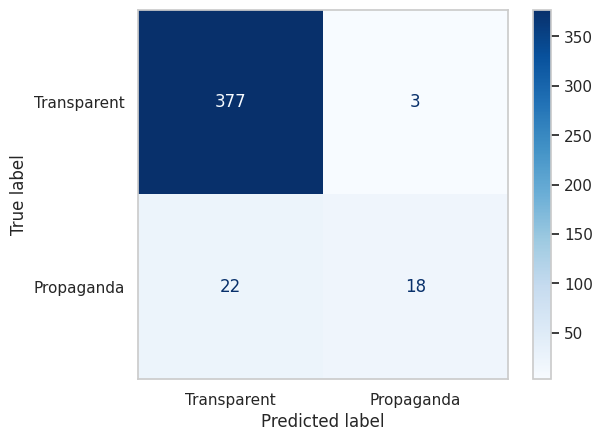

In [45]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)


disp.plot(cmap="Blues")
plt.show()

In [46]:
trainer.save_model(model_path)

In [47]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.66k [00:00<?, ?B/s]

events.out.tfevents.1700147192.n5c736lia9.2525.0:   0%|          | 0.00/5.69k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

events.out.tfevents.1700148004.n5c736lia9.2525.1:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

'https://huggingface.co/Bmalmotairy/arabertv2-weakly-supervised-arabic-propaganda/tree/main/'

In [48]:
wandb.finish()

eval/Accuracy,▁
eval/F1,▁
eval/Precision,▁
eval/Recall,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
test/Accuracy,▁
test/F1,▁
test/Precision,▁
